#Zinidi UmojaHack SA 2020

##Descriprion

Ride-hailing apps like Uber and Yassir rely on real-time data and machine learning algorithms to automate their services. Accurately predicting the estimated time of arrival (ETA) for Yassir trips will make Yassir’s services more reliable and attractive; this will have a direct and indirect impact on both customers and business partners. The solution would help the company save money and allocate more resources to other parts of the business.

The objective of this hackathon is to predict the estimated time of arrival at the dropoff point for a single Yassir journey. Established in 2017, Yassir is the leading ride-hailing company in Algeria. It covers all major Algerian cities and is expanding its services to Tunisia, Morocco and France. Besides ride-hailing services, Yassir is making customers’ lives easier by providing diversified services such as goods and food delivery as well as telemedicine.


## Data

Please find the data [here](https://zindi.africa/hackathons/umojahack-south-africa-yassir-eta-prediction-challenge/data) on Zindi.


The data contains details for 119,549 trips (train and test are split by date). Each row contains a start location and end location (reported as latitude and longitude to within approximately 100m) and the travel distance along the fastest route. Each trip also has a timestamp, which can be used to pull the weather for that day from Weather.csv file. The weather data includes temperature, rainfall and wind speed for the time period during which the trip data was collected.


Files available for download:
Train.csv - contains the input variables and the target, 

*   Train.csv - contains the input variables and the target, ‘ETA’
*  Test.csv - matches Train.csv but without the ETA
*  SampleSubmission.csv - is an example of what your submission file should look like. The order of the rows does not matter, but the names of the IDs must be correct.
*   Weather.csv - contains daily weather summaries, based on data from the ERA5 dataset.

Variable Descriptions:
'ID' - A unique ID

* 'Timestamp' - Time that the trip was started
* 'Origin_lat', 'Origin_lon' - Origin (in degrees latitude and longitude)
* 'Destination_lat', 'Destination_lon' - Destination
* 'Trip_distance' - Distance in meters on a driving route
* 'ETA' - Estimated trip time in seconds


#Importing the libraries

In [ ]:
import pandas as pd
import numpy as np
import pylab as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import cluster
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn import pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
 
%matplotlib inline

#Loading Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Train.csv to Train.csv


In [ ]:
import io

In [ ]:
train = pd.read_csv(io.BytesIO(uploaded['Train.csv'])).set_index('ID')
train['Timestamp'] = pd.to_datetime(train['Timestamp'])
train.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA
ID,,,,,,,
000FLWA8,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627,2784
000RGOAM,2019-12-10 22:37:09+00:00,3.087,36.707,3.081,36.727,3918,576
001QSGIH,2019-11-23 20:36:10+00:00,3.144,36.739,3.088,36.742,7265,526
002ACV6R,2019-12-01 05:43:21+00:00,3.239,36.784,3.054,36.763,23350,3130
0039Y7A8,2019-12-17 20:30:20+00:00,2.912,36.707,3.207,36.698,36613,2138


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83924 entries, 000FLWA8 to ZZZY11ZN
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Timestamp        83924 non-null  datetime64[ns, UTC]
 1   Origin_lat       83924 non-null  float64            
 2   Origin_lon       83924 non-null  float64            
 3   Destination_lat  83924 non-null  float64            
 4   Destination_lon  83924 non-null  float64            
 5   Trip_distance    83924 non-null  int64              
 6   ETA              83924 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(2)
memory usage: 5.1+ MB


In [ ]:
train.describe()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA
count,83924.000000,83924.000000,83924.000000,83924.000000,83924.000000,83924.000000
mean,3.052406,36.739358,3.056962,36.737732,13527.821410,1111.697762
std,0.096388,0.032074,0.100710,0.032781,9296.716006,563.565486
min,2.807000,36.589000,2.807000,36.596000,1.000000,1.000000
25%,2.994000,36.721000,2.995000,36.718000,6108.000000,701.000000
50%,3.046000,36.742000,3.049000,36.742000,11731.500000,1054.000000
75%,3.095000,36.760000,3.109000,36.760000,19369.000000,1456.000000
max,3.381000,36.820000,3.381000,36.819000,62028.000000,5238.000000


In [ ]:
uploaded = files.upload()

Saving Test.csv to Test.csv


In [ ]:
test = pd.read_csv(io.BytesIO(uploaded['Test.csv'])).set_index('ID')
test['Timestamp'] = pd.to_datetime(test['Timestamp'])
test.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance
ID,,,,,,
000V4BQX,2019-12-21 05:52:37+00:00,2.981,36.688,2.978,36.754,17549
003WBC5J,2019-12-25 21:38:53+00:00,3.032,36.769,3.074,36.751,7532
004O4X3A,2019-12-29 21:30:29+00:00,3.035,36.711,3.010,36.758,10194
006CEI5B,2019-12-31 22:51:57+00:00,2.902,36.738,3.208,36.698,32768
009G0M2T,2019-12-28 21:47:22+00:00,2.860,36.692,2.828,36.696,4513


In [ ]:
test.describe()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance
count,35625.000000,35625.000000,35625.000000,35625.00000,35625.000000
mean,3.052552,36.739741,3.055438,36.73826,13646.033684
std,0.096975,0.032631,0.099085,0.03301,9211.279046
min,2.806000,36.592000,2.810000,36.59200,2.000000
25%,2.993000,36.721000,2.996000,36.71800,6398.000000
50%,3.048000,36.743000,3.049000,36.74200,11906.000000
75%,3.098000,36.761000,3.106000,36.76100,19291.000000
max,3.376000,36.819000,3.372000,36.81800,61958.000000


In [ ]:
uploaded = files.upload()

Saving Weather.csv to Weather.csv


In [ ]:
weather = pd.read_csv(io.BytesIO(uploaded['Weather.csv']))
weather.head()

,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
0,2019-11-01,290.630524,296.434662,294.125061,101853.617188,292.503998,100806.351562,0.004297,3.561323,0.941695
1,2019-11-02,289.135284,298.432404,295.551666,101225.164062,293.337921,100187.250000,0.001767,5.318593,3.258237
2,2019-11-03,287.667694,296.612122,295.182831,100806.617188,293.674316,99771.414062,0.000797,8.447649,3.172982
3,2019-11-04,287.634644,297.173737,294.368134,101240.929688,292.376221,100200.843750,0.000393,5.991428,2.236700
4,2019-11-05,286.413788,294.284851,292.496979,101131.750000,289.143066,100088.500000,0.004658,6.962730,2.655364


In [ ]:
weather.describe()

,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,6.000000e+01,60.000000,60.000000
mean,283.433978,291.415515,288.765101,101576.596354,286.091840,100522.155990,2.770091e-03,2.973112,1.340900
std,2.312254,2.511992,2.444578,676.467225,2.641365,668.499214,5.554755e-03,3.482151,1.574765
min,279.411621,285.989594,284.518982,100172.914062,282.348389,99133.382812,-4.284084e-08,-5.210768,-2.041836
25%,281.558868,289.473083,287.173805,101127.173828,284.431366,100084.947266,8.062460e-06,0.052387,0.487160
50%,283.328842,291.233856,288.423889,101437.671875,285.691422,100389.984375,3.450802e-04,3.585083,1.090567
75%,284.810516,293.102837,289.868317,102014.974609,286.892906,100962.218750,3.609773e-03,5.524293,2.473923
max,290.630524,298.432404,295.551666,103127.242188,293.674316,102044.125000,2.992217e-02,9.466430,6.000363


In [ ]:
uploaded = files.upload()

Saving SampleSubmission.csv to SampleSubmission.csv


In [ ]:
submissionSample = pd.read_csv(io.BytesIO(uploaded['SampleSubmission.csv']))
submissionSample.head()

,ID,ETA
0,000V4BQX,0
1,003WBC5J,0
2,004O4X3A,0
3,006CEI5B,0
4,009G0M2T,0


#EDA

The EDA of the dataset was conducted by another member of the team and therefore, its not included in this notebok.

#Feature Engineering

We are only going to engineer time and location related features to use in the model.

Joining train and test sets for feature engineering.

In [ ]:
train['traintest'] = 1
test['traintest'] = 0
data = pd.concat([train,test], axis = 0)
data.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,traintest
ID,,,,,,,,
000FLWA8,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627,2784.0,1
000RGOAM,2019-12-10 22:37:09+00:00,3.087,36.707,3.081,36.727,3918,576.0,1
001QSGIH,2019-11-23 20:36:10+00:00,3.144,36.739,3.088,36.742,7265,526.0,1
002ACV6R,2019-12-01 05:43:21+00:00,3.239,36.784,3.054,36.763,23350,3130.0,1
0039Y7A8,2019-12-17 20:30:20+00:00,2.912,36.707,3.207,36.698,36613,2138.0,1


##Time Features

Extracting the hour of delivery from each timestamp.

In [ ]:
data['hour'] = data['Timestamp'].dt.hour

Extracting the day of week of delivery from each timestamp.

In [ ]:
data['dayofweek'] = data['Timestamp'].dt.dayofweek

In [ ]:
data.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,traintest,hour,dayofweek
ID,,,,,,,,,,
000FLWA8,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627,2784.0,1,20,2
000RGOAM,2019-12-10 22:37:09+00:00,3.087,36.707,3.081,36.727,3918,576.0,1,22,1
001QSGIH,2019-11-23 20:36:10+00:00,3.144,36.739,3.088,36.742,7265,526.0,1,20,5
002ACV6R,2019-12-01 05:43:21+00:00,3.239,36.784,3.054,36.763,23350,3130.0,1,5,6
0039Y7A8,2019-12-17 20:30:20+00:00,2.912,36.707,3.207,36.698,36613,2138.0,1,20,1


##Weather Features

In [ ]:
#weather['date'] = pd.to_datetime(weather['date'])

In [ ]:
#weather['date'].nunique()

60

##Location Features

Creating zones to categorize pickup and destination lat and long in zones as an extra feature.

In [ ]:
location = data[['Origin_lat', 'Origin_lon', 'Destination_lat', 'Destination_lon']]
location.head()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon
ID,,,,
000FLWA8,3.258,36.777,3.003,36.718
000RGOAM,3.087,36.707,3.081,36.727
001QSGIH,3.144,36.739,3.088,36.742
002ACV6R,3.239,36.784,3.054,36.763
0039Y7A8,2.912,36.707,3.207,36.698


In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Using the Elbow curve to investigate the number of clusters required from the pickup destinations (origin lat and long)

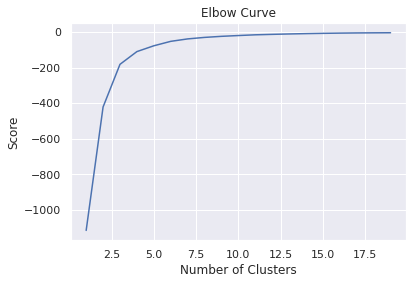

In [ ]:
K_clusters = range(1,20)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = location[['Origin_lat']]
X_axis = location[['Origin_lon']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

From the elbow curve we are going to use k=10, hence generating 10 different zones for pickup and destination points.

In [ ]:
kmeans = KMeans(n_clusters = 10, init ='k-means++',random_state=1)

pickup = kmeans.fit(location[['Origin_lat',
                              'Origin_lon']]) # Compute k-means clustering.

destination = kmeans.fit(location[['Destination_lat', 
                                  'Destination_lon']]) # Compute k-means clustering.


location['Pickup_zone'] = kmeans.fit_predict(location[['Origin_lat','Origin_lon']])
location['Destination_zone'] = kmeans.fit_predict(location[['Destination_lat','Destination_lon']])

centers = kmeans.cluster_centers_ # Coordinates of cluster centers.

labels_p= kmeans.predict(location[location.columns[1:3]]) # Labels of each point
labels_d= kmeans.predict(location[location.columns[3:5]]) # Labels of each point

location.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Pickup_zone,Destination_zone
ID,,,,,,
000FLWA8,3.258,36.777,3.003,36.718,6,3
000RGOAM,3.087,36.707,3.081,36.727,5,0
001QSGIH,3.144,36.739,3.088,36.742,3,0
002ACV6R,3.239,36.784,3.054,36.763,6,6
0039Y7A8,2.912,36.707,3.207,36.698,8,8
003B9LE9,2.995,36.738,3.207,36.698,4,8
004K2C9W,3.054,36.773,3.059,36.785,1,6
004LD40Z,3.092,36.711,3.035,36.734,3,3
005H5Q6S,3.178,36.722,3.197,36.713,0,8


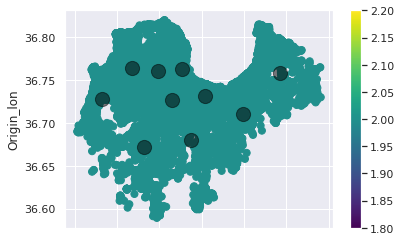

In [ ]:
location.plot.scatter(x = 'Origin_lat', y = 'Origin_lon', c=labels_p, s=50, cmap='viridis',)
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5,)

The above plot shows the 10 origin (pickup) zones created from k-means.

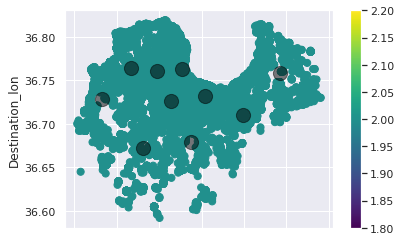

In [ ]:
location.plot.scatter(x = 'Destination_lat', y = 'Destination_lon', c=labels_d, s=50, cmap='viridis',)
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

The above plot shows the 10 destination zones created from k-means.

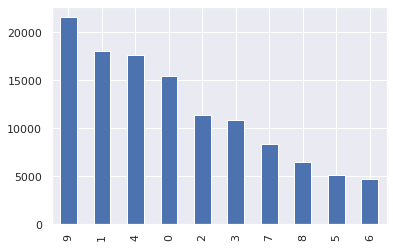

In [ ]:
location['Pickup_zone'].value_counts().plot(kind="bar")

Most orders come from zone 9 and the least orders from 6.

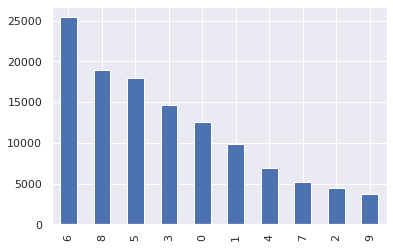

In [ ]:
location['Destination_zone'].value_counts().plot(kind="bar")

Most orders are delivered to zone 6 and the least to zone 9.

In [ ]:
location.head()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Pickup_zone,Destination_zone
ID,,,,,,
000FLWA8,3.258,36.777,3.003,36.718,6,3
000RGOAM,3.087,36.707,3.081,36.727,5,0
001QSGIH,3.144,36.739,3.088,36.742,3,0
002ACV6R,3.239,36.784,3.054,36.763,6,6
0039Y7A8,2.912,36.707,3.207,36.698,8,8


You can try think more features which can be created from the above zones.

In [ ]:
data['Destination_zone'] = location['Destination_zone']
data['Pickup_zone'] = location['Pickup_zone']
data.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,traintest,hour,dayofweek,Destination_zone,Pickup_zone
ID,,,,,,,,,,,,
000FLWA8,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627,2784.0,1,20,2,3,6
000RGOAM,2019-12-10 22:37:09+00:00,3.087,36.707,3.081,36.727,3918,576.0,1,22,1,0,5
001QSGIH,2019-11-23 20:36:10+00:00,3.144,36.739,3.088,36.742,7265,526.0,1,20,5,0,3
002ACV6R,2019-12-01 05:43:21+00:00,3.239,36.784,3.054,36.763,23350,3130.0,1,5,6,6,6
0039Y7A8,2019-12-17 20:30:20+00:00,2.912,36.707,3.207,36.698,36613,2138.0,1,20,1,8,8


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119549 entries, 000FLWA8 to ZZZYTWJA
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   Timestamp         119549 non-null  datetime64[ns, UTC]
 1   Origin_lat        119549 non-null  float64            
 2   Origin_lon        119549 non-null  float64            
 3   Destination_lat   119549 non-null  float64            
 4   Destination_lon   119549 non-null  float64            
 5   Trip_distance     119549 non-null  int64              
 6   ETA               83924 non-null   float64            
 7   traintest         119549 non-null  int64              
 8   hour              119549 non-null  int64              
 9   dayofweek         119549 non-null  int64              
 10  Destination_zone  119549 non-null  int32              
 11  Pickup_zone       119549 non-null  int32              
dtypes: datetime64[ns, UTC](1), float64(5), i

In [ ]:
#data['log_dist'] = np.log(data['trip_distance'])

In [ ]:
#data['log_precip'] = np.log(data['total_precipitation'])

In [ ]:
#data['wind_direction'] = np.sqrt((np.square(data['u_component_of_wind_10m'])+ np.square(data['u_component_of_wind_10m'])))

#Split

Split data to train and test sets.

In [ ]:
train = data[data['traintest'] == 1]
test = data[data['traintest'] == 0]

In [ ]:
train.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,traintest,hour,dayofweek,Destination_zone,Pickup_zone
ID,,,,,,,,,,,,
000FLWA8,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627,2784.0,1,20,2,3,6
000RGOAM,2019-12-10 22:37:09+00:00,3.087,36.707,3.081,36.727,3918,576.0,1,22,1,0,5
001QSGIH,2019-11-23 20:36:10+00:00,3.144,36.739,3.088,36.742,7265,526.0,1,20,5,0,3
002ACV6R,2019-12-01 05:43:21+00:00,3.239,36.784,3.054,36.763,23350,3130.0,1,5,6,6,6
0039Y7A8,2019-12-17 20:30:20+00:00,2.912,36.707,3.207,36.698,36613,2138.0,1,20,1,8,8


In [ ]:
'''
features = ['origin_lat','origin_lon','destination_lat','destination_lon',
            'trip_distance', 'hour', 'dayofweek',
            'mean_2m_air_temperature','mean_sea_level_pressure',
            'surface_pressure','total_precipitation',
            'Pickup_zone','Destination_zone','log_dist','log_precip','wind_direction']
'''       

In [ ]:
features = ['Origin_lat','Origin_lon','Destination_lat','Destination_lon',
            'Trip_distance', 'hour', 'dayofweek','Pickup_zone','Destination_zone']


In [ ]:
X = train[features]
y = train['ETA']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25)

#CatBoost

In [ ]:
#pip install catboost

     |████████████████████████████████| 64.8MB 64kB/s 


In [ ]:
from catboost import CatBoostRegressor

With the right tune and iterations above 5000, it should get you a good RMSE score of under 160.

In [ ]:
model_cb = CatBoostRegressor(iterations=5000,
                          depth=6,
                          l2_leaf_reg=3,
                          learning_rate = 0.05,
                          eval_metric = "RMSE",
                          random_state = 1)

List of features in the training set

In [ ]:
list(train)

['Timestamp',
 'Origin_lat',
 'Origin_lon',
 'Destination_lat',
 'Destination_lon',
 'Trip_distance',
 'ETA',
 'traintest',
 'hour',
 'dayofweek',
 'Destination_zone',
 'Pickup_zone']

List of categorical features.

In [ ]:
cat_features = ['hour','dayofweek','Destination_zone','Pickup_zone']

##Tune the model 

In [ ]:
model = CatBoostRegressor(eval_metric = "RMSE",
                          iterations = 2000,
                          random_state = 1)
grid = {'learning_rate': [0.01, 0.05, 0.1],
        'depth': [3, 4, 6],
        'l2_leaf_reg': [1, 2]}

grid_search_result = model.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train,
                                       cv=10,
                                       partition_random_seed=0,
                                        calc_cv_statistics=True,
                                        search_by_train_test_split=True,
                                        refit=True,
                                        shuffle=True,
                                        stratified=None,
                                        train_size=0.8,
                                        verbose=True,
                                       plot=True)

Evaluate the tune model parameters that you set on to model_cb onto the X_test and y_test.

In [ ]:
model_cb.fit(X_train, y_train,cat_features = cat_features,
             plot= True, eval_set=(X_test,y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 542.0634022	test: 538.7592135	best: 538.7592135 (0)	total: 77.5ms	remaining: 1m 17s
1:	learn: 521.3239780	test: 517.9268427	best: 517.9268427 (1)	total: 160ms	remaining: 1m 19s
2:	learn: 501.5303500	test: 498.0450041	best: 498.0450041 (2)	total: 248ms	remaining: 1m 22s
3:	learn: 483.2842706	test: 479.6499379	best: 479.6499379 (3)	total: 329ms	remaining: 1m 21s
4:	learn: 465.6191493	test: 461.8634241	best: 461.8634241 (4)	total: 405ms	remaining: 1m 20s
5:	learn: 449.3764525	test: 445.4733432	best: 445.4733432 (5)	total: 489ms	remaining: 1m 21s
6:	learn: 433.8595612	test: 429.8517666	best: 429.8517666 (6)	total: 568ms	remaining: 1m 20s
7:	learn: 419.6048100	test: 415.4821613	best: 415.4821613 (7)	total: 642ms	remaining: 1m 19s
8:	learn: 405.7759256	test: 401.6187123	best: 401.6187123 (8)	total: 722ms	remaining: 1m 19s
9:	learn: 392.9531135	test: 388.7462983	best: 388.7462983 (9)	total: 816ms	remaining: 1m 20s
10:	learn: 380.6658959	test: 376.4021704	best: 376.4021704 (10)	total

In [ ]:
#cb_preds = model_cb.predict(X_test)

In [ ]:
#print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, cb_preds)))

RMSE:  132.8026455186074


Fitting the best model on all the training data.

In [ ]:
model_cb.fit(train[features], train['ETA'], cat_features=cat_features)

Streaming output truncated to the last 5000 lines.
1:	learn: 521.1637103	total: 187ms	remaining: 7m 47s
2:	learn: 501.9183613	total: 270ms	remaining: 7m 29s
3:	learn: 483.8268939	total: 357ms	remaining: 7m 26s
4:	learn: 466.3133017	total: 437ms	remaining: 7m 16s
5:	learn: 450.0751231	total: 512ms	remaining: 7m 6s
6:	learn: 434.6299395	total: 589ms	remaining: 6m 59s
7:	learn: 420.0026317	total: 667ms	remaining: 6m 56s
8:	learn: 406.4386739	total: 735ms	remaining: 6m 47s
9:	learn: 393.5794176	total: 809ms	remaining: 6m 43s
10:	learn: 381.5965402	total: 885ms	remaining: 6m 41s
11:	learn: 370.4004067	total: 951ms	remaining: 6m 35s
12:	learn: 359.7527100	total: 1.02s	remaining: 6m 33s
13:	learn: 349.8477808	total: 1.1s	remaining: 6m 32s
14:	learn: 340.6529587	total: 1.18s	remaining: 6m 33s
15:	learn: 331.9512246	total: 1.26s	remaining: 6m 33s
16:	learn: 323.6956975	total: 1.33s	remaining: 6m 29s
17:	learn: 315.9242858	total: 1.4s	remaining: 6m 28s
18:	learn: 308.6598428	total: 1.48s	remaini

#Submission

Predictions

In [ ]:
test['ETA'] = model_cb.predict(test[features])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test.describe()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,traintest,hour,dayofweek,Destination_zone,Pickup_zone
count,35625.000000,35625.000000,35625.000000,35625.00000,35625.000000,35625.000000,35625.0,35625.000000,35625.000000,35625.000000,35625.000000
mean,3.052552,36.739741,3.055438,36.73826,13646.033684,1126.489052,0.0,15.053558,3.027116,4.625291,4.161712
std,0.096975,0.032631,0.099085,0.03301,9211.279046,534.952022,0.0,8.837858,2.118591,2.631352,3.141399
min,2.806000,36.592000,2.810000,36.59200,2.000000,-77.791366,0.0,0.000000,0.000000,0.000000,0.000000
25%,2.993000,36.721000,2.996000,36.71800,6398.000000,733.156804,0.0,5.000000,1.000000,3.000000,1.000000
50%,3.048000,36.743000,3.049000,36.74200,11906.000000,1074.782267,0.0,20.000000,3.000000,5.000000,4.000000
75%,3.098000,36.761000,3.106000,36.76100,19291.000000,1454.369091,0.0,21.000000,5.000000,6.000000,7.000000
max,3.376000,36.819000,3.372000,36.81800,61958.000000,4675.701650,0.0,23.000000,6.000000,9.000000,9.000000


In [ ]:
test.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,traintest,hour,dayofweek,Destination_zone,Pickup_zone
ID,,,,,,,,,,,,
000V4BQX,2019-12-21 05:52:37+00:00,2.981,36.688,2.978,36.754,17549,1285.120547,0,5,5,5,7
003WBC5J,2019-12-25 21:38:53+00:00,3.032,36.769,3.074,36.751,7532,810.816528,0,21,2,6,1
004O4X3A,2019-12-29 21:30:29+00:00,3.035,36.711,3.010,36.758,10194,1025.273315,0,21,6,5,9
006CEI5B,2019-12-31 22:51:57+00:00,2.902,36.738,3.208,36.698,32768,1832.777856,0,22,1,8,8
009G0M2T,2019-12-28 21:47:22+00:00,2.860,36.692,2.828,36.696,4513,689.112022,0,21,5,4,8


In [ ]:
test['ETA']

ID
000V4BQX    1285.120547
003WBC5J     810.816528
004O4X3A    1025.273315
006CEI5B    1832.777856
009G0M2T     689.112022
               ...     
ZZXSJW3Q     402.290989
ZZYPNYYY    1133.911036
ZZYVPKXY     644.819091
ZZZXGRIO    1224.206361
ZZZYTWJA     658.776361
Name: ETA, Length: 35625, dtype: float64

#Downloading the submission csv file

In [ ]:
test['ETA'].to_csv('submission.csv', sep=',', index = True)

In [ ]:
from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

At the time of submission on 28/07/2020, the results from model_cb have an RMSE score of 152.79, which qualifies for the seventh position on the hackathon's leaderboard.

#Reccommendations
To get a better score on this challenge, more time can be dedicated on experimentation with other methods and techniques. For example the model could be improved with feature engineering, from the weather.csv file and extraction of more insights from time and location variables.

Also, you can try out other tree algorithms such as XGBoost to see if the results get better.